# Text Classification

In [58]:
from datasets import list_datasets, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn.functional as F

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## The Dataset

In [2]:
[x for x in list_datasets() if x.startswith('emo')]

['emo', 'emotion', 'emotone_ar']

In [3]:
emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<hr>

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
emotions["train"][0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### Set Dataset Format

Set format to `pandas` to work with DataFrame object.

In [7]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
emotions['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [71]:
labels = emotions['train'].features['label']

In [10]:
df['label_name'] = df['label'].apply(labels.int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


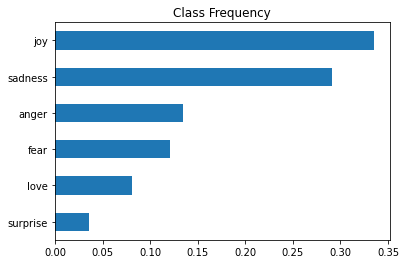

In [11]:
df['label_name'].value_counts(normalize=True, ascending=True).plot.barh()
plt.title('Class Frequency')
plt.show()

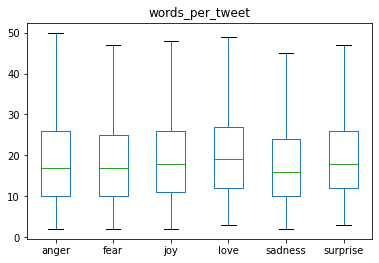

In [12]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot(
    'words_per_tweet',
    by='label_name',
    showfliers=False,
    grid=False
)
plt.suptitle('')
plt.xlabel('')
plt.show()

### Reset Dataset Format

Reset format for further work.

In [13]:
emotions.reset_format()

## Tokenization

In [15]:
ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [18]:
text = emotions["train"][0]['text']
encoded_text = tokenizer(text)
print(text)
print(encoded_text)

i didnt feel humiliated
{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'didn', '##t', 'feel', 'humiliated', '[SEP]']


In [21]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i didnt feel humiliated [SEP]


In [22]:
tokenizer.max_model_input_sizes

{'distilbert-base-uncased': 512,
 'distilbert-base-uncased-distilled-squad': 512,
 'distilbert-base-cased': 512,
 'distilbert-base-cased-distilled-squad': 512,
 'distilbert-base-german-cased': 512,
 'distilbert-base-multilingual-cased': 512}

In [23]:
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [24]:
print(tokenize_batch(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [25]:
emotions_enc = emotions.map(function=tokenize_batch, batched=True, batch_size=None)

Parameter 'function'=<function tokenize_batch at 0x7f5c6d6b1ca0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
emotions_enc['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [29]:
emotions_enc['train'][0]['text']

'i didnt feel humiliated'

In [32]:
print(emotions_enc['train'][0]['input_ids'])

[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<hr>

## Fine Tuning

In [39]:
NUM_LABELS = 6
MODEL_CKPT = 'distilbert-base-uncased'

model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_LABELS).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [40]:
def get_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [45]:
bs = 64
logging_steps = len(emotions_enc['train']) // bs
model_name = f'{MODEL_CKPT}-ft-emotion'

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=1e-5,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error'
)

In [46]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=get_metrics,
    train_dataset=emotions_enc['train'],
    eval_dataset=emotions_enc['validation'],
    tokenizer=tokenizer
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.999600,0.569454,0.813000,0.788442
2,0.478900,0.404981,0.882000,0.876991


TrainOutput(global_step=500, training_loss=0.7392918090820313, metrics={'train_runtime': 577.1368, 'train_samples_per_second': 55.446, 'train_steps_per_second': 0.866, 'total_flos': 720342861696000.0, 'train_loss': 0.7392918090820313, 'epoch': 2.0})

In [47]:
preds_output = trainer.predict(emotions_enc['validation'])
preds_output.metrics

{'test_loss': 0.4049813151359558,
 'test_accuracy': 0.882,
 'test_f1': 0.8769910032320454,
 'test_runtime': 11.115,
 'test_samples_per_second': 179.937,
 'test_steps_per_second': 2.879}

In [53]:
def plot_confusion_matrix(preds, actuals, labels):
    cm = confusion_matrix(actuals, preds, normalize='true')
    fig, ax = plt.subplots(figsize=(NUM_LABELS, NUM_LABELS))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=True)
    plt.title('Normalized Confusion Matrix')
    plt.show()

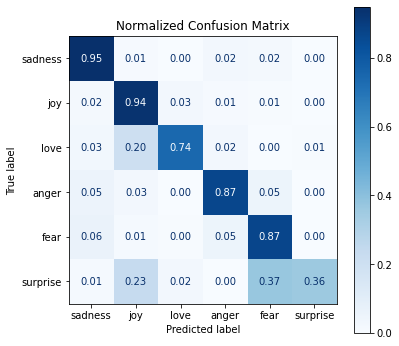

In [72]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = emotions_enc['validation']['label']
label_names = emotions['train'].features['label'].names

plot_confusion_matrix(y_preds, y_valid, label_names)

## Error Analysis

In [64]:
def forward_pass(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = F.cross_entropy(output.logits, batch['label'].to(device), reduction='none')
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

In [65]:
emotions_enc.set_format(
    'torch',
    columns=['input_ids', 'attention_mask', 'label']
)

emotions_enc['validation'] = emotions_enc['validation'].map(forward_pass, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [73]:
emotions_enc.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']

df_valid = emotions_enc['validation'][:][cols]
df_valid['label'] = df_valid['label'].apply(labels.int2str)
df_valid['predicted_label'] = df_valid['predicted_label'].apply(labels.int2str)

In [79]:
df_valid.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,4.512939
1801,i feel that he was being overshadowed by the s...,love,sadness,4.415724
882,i feel badly about reneging on my commitment t...,love,sadness,4.414670
1950,i as representative of everything thats wrong ...,surprise,sadness,4.384918
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.368762
1274,i am going to several holiday parties and i ca...,joy,sadness,4.260564
765,i feel super awkward and out of place right now,joy,sadness,4.181100
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.062706
465,i would eventually go in to these stores but i...,joy,fear,4.061491
1509,i guess this is a memoir so it feels like that...,joy,fear,3.982091


In [78]:
df_valid.sort_values('loss').head()

,text,label,predicted_label,loss
1062,i feel successful in balancing my paid work an...,joy,joy,0.044414
904,im also eating much more nutritious food and f...,joy,joy,0.044505
1618,i had a good feeling about the presentation an...,joy,joy,0.044680
19,i had lunch with an old friend and it was nice...,joy,joy,0.044803
726,i feel too energetic and some days i just feel...,joy,joy,0.044889
